## Get site image

In [39]:
import requests
import json
import re
import csv

In [40]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [43]:
import requests
import json
import re
import csv

directory_path = os.getcwd()

def get_osm_id(address):
    print(address)
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': address,
        'format': 'json',
        'limit': 1
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            center_coordinate = float(data[0].get("lon")), float(data[0].get("lat"))
            osm_id = data[0]['osm_id']
            return osm_id, center_coordinate
        else:
            print("No results found for the address.")
            return None
    else:
        print("Error:", response.status_code)
        return None

def get_coordinates_of_way(osm_id):
    overpass_url = "http://overpass-api.de/api/interpreter"
    way_query = f"""
    [out:json];
    way({osm_id});
    out geom;
    """

    try:
        response = requests.get(overpass_url, params={'data': way_query})
        response.raise_for_status()
        way_data = response.json()
        if not way_data['elements']:
            print(f"Way {osm_id} not found!")
            return []

        coords = way_data['elements'][0]['geometry']
        return [(point['lat'], point['lon']) for point in coords]

    except requests.RequestException as e:
        print(f"Error fetching data for way {osm_id} from Overpass API: {e}")
        return []


def coordinates_to_geojson(coordinates, osm_type='way'):
    if not coordinates or coordinates[0] != coordinates[-1]:
        print("The provided coordinates do not form a closed loop. Cannot create a Polygon.")
        return None

    # Flip the coordinates from (lat, lon) to (lon, lat)
    flipped_coordinates = [[lon, lat] for lat, lon in coordinates]
    
    return flipped_coordinates

def main(address):
    osm_id, center_coordinates = get_osm_id(address)
    if osm_id is None:
        return
    location = get_coordinates_of_way(osm_id)
    geojson = coordinates_to_geojson(location)
    return osm_id, center_coordinates, location, geojson

address = '33 residences'
_, center_coord, _, geojson = main(address)
print(center_coord)
print(geojson)

geojson_feature = {
    "type": "Feature",
    "properties": {
        "fill": "#00FF00",
        "fill-opacity": "1.0"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [geojson],

    }
}
geojson_str = json.dumps(geojson_feature)
encoded_geojson = requests.utils.quote(geojson_str)


# Replace the placeholder values with your actual data
access_token = 'sk.eyJ1IjoieWVuY2hpbmdwIiwiYSI6ImNsb3FrZ2U1czBqZjkycWx3cXVlbDRzOXkifQ.hTjiIfuNE7I-KhYqJfQkFw'  # Replace with your Mapbox access token
lon, lat = center_coord  # Replace with the center longitude and latitude of your GeoJSON
zoom = 16.5  # Set the zoom level as needed
width, height = 512, 512 # this means 1024 x1024 as mapbox sot one
style_id = 'clogxdq2i007r01qr5gmsc907' #clogyeist005901nzfv9veyfa

# Construct the API request URL
pink_site = f"https://api.mapbox.com/styles/v1/zyjy118/{style_id}/static/{lon},{lat},{zoom}/{width}x{height}@2x?access_token={access_token}"
pink_mask_site = f"https://api.mapbox.com/styles/v1/zyjy118/{style_id}/static/geojson({encoded_geojson})/{lon},{lat},{zoom}/{width}x{height}@2x?access_token={access_token}"
og_site = f"https://api.mapbox.com/styles/v1/mapbox/streets-v11/static/{lon},{lat},{zoom}/{width}x{height}@2x?access_token={access_token}"
# Send the GET request
response1 = requests.get(og_site)
response2 = requests.get(pink_site)
response3 = requests.get(pink_mask_site)

if response1.status_code == 200:
    # Save the image to a file
    with open(os.path.join(directory_path, 'og_site.jpg'), 'wb') as image_file:
        image_file.write(response1.content)
    print('OG Site saved successfully!')
else:
    print(f"Failed to retrieve the image: {response1.status_code} - {response1.content}")

if response2.status_code == 200:
    # Save the image to a file
    with open(os.path.join(directory_path, 'pink_site.jpg'), 'wb') as image_file:
        image_file.write(response2.content)
    print('Pink site saved successfully!')
else:
    print(f"Failed to retrieve the masked image: {response2.status_code} - {response2.content}")

if response3.status_code == 200:
    # Save the image to a file
    with open(os.path.join(directory_path, 'pink_site_mask.jpg'), 'wb') as image_file:
        image_file.write(response3.content)
    print('Masked pink saved successfully!')
else:
    print(f"Failed to retrieve the masked image: {response3.status_code} - {response3.content}")

33 residences
(103.88651674763108, 1.3119672)
[[103.8864288, 1.312053], [103.8866031, 1.3120584], [103.8866112, 1.3118814], [103.8864234, 1.3118733], [103.8864288, 1.312053]]
OG Site saved successfully!
Pink site saved successfully!
Masked pink saved successfully!


## Prepare input image for model

In [44]:
mask_image_path = os.path.join(directory_path, 'pink_site_mask.jpg')

# convert image to 512 x 512
mask_image = Image.open(mask_image_path)

# Resize the image
input_image = mask_image.resize((512, 512))

## Load the trained model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

1/1 [==============================] - 1s 647ms/step


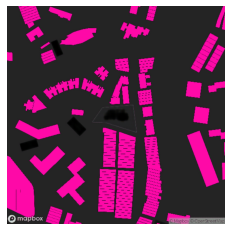

In [ ]:
# Load the model
model = load_model(os.path.join(directory_path, 'generatorv40rd.h5'))

# Load and prepare the input image
mask_image_path = os.path.join(directory_path, 'pink_site_mask.jpg')
input_img = image.load_img(mask_image_path, target_size=(512, 512))  # Adjust as per your model's input size
input_img_array = image.img_to_array(input_img)
input_img_array = (input_img_array - 127.5) / 127.5  # Normalize the image to [-1, 1] if that's how the model was trained
input_img_array = np.expand_dims(input_img_array, axis=0)  # Model expects a batch of images

# Generate the output image
output_img_array = model.predict(input_img_array)

# Post-process the output image
output_img_array = (output_img_array * 0.5) + 0.5  # Rescale back to [0, 1] if the model was trained on [-1, 1] normalized images
output_img_array = np.squeeze(output_img_array)  # Remove the batch dimension
output_img_array = output_img_array * 255 
output_array = output_img_array.astype(np.uint8)
generated_image = Image.fromarray(output_array) 

# Display the output image
plt.imshow(generated_image)
plt.axis('off')
plt.show()

## Show site area

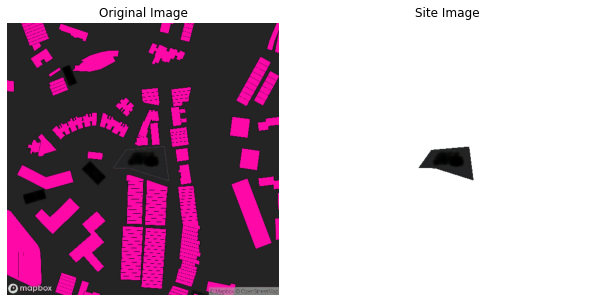

In [ ]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

# Load the images
mask_image = Image.open(os.path.join(directory_path, 'pink_site_mask.jpg'))

# Resize the image
mask_image = mask_image.resize((512, 512))

# convert grayscale to RGB
if mask_image.mode != 'RGB':
    mask_image = mask_image.convert('RGB')
if generated_image.mode != 'RGB':
    generated_image = generated_image.convert('RGB')

# Convert images to numpy arrays
mask_array = np.array(mask_image)
original_array = np.array(generated_image)

# Create site mask
def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [4, 255, 0]  # bright green
site_mask = create_binary_mask(mask_array, mask_color)

# Extract site from the original image that corresponds to the blue mask
site_area_array = original_array.copy()
site_area_array[~site_mask] = [255, 255, 255]  # making non-masked region white

# Convert site_area back to a PIL image and enhance its contrast
site_area_image = Image.fromarray(site_area_array)


# Display the result
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(site_area_image)
plt.title('Site Image')
plt.axis('off')
plt.show()



## Extract buildings

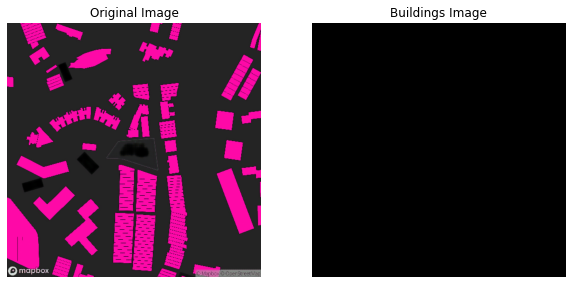

In [ ]:
#detect buildings
def extract_building_regions(arr, target_color, threshold=10):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [250, 8, 162]  # bright pink
building_mask = extract_building_regions(site_area_array, mask_color)

buildings_image = Image.fromarray(building_mask)


# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.show()

## Draw contours

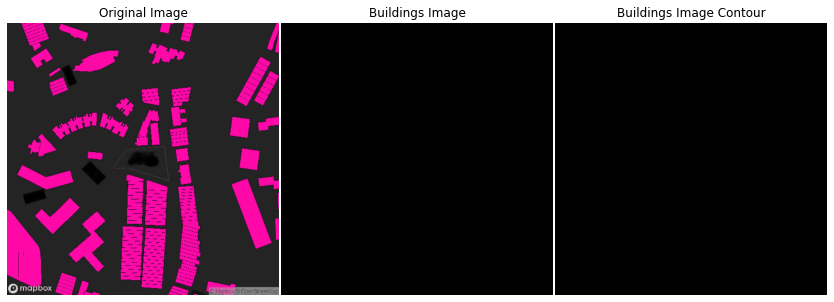

In [ ]:
def approx_contours(contours, epsilon_factor=0.02):
    approximated_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approximated_contours.append(approx)
    return approximated_contours

# convert mask to uint8 instead of bool
building_mask = building_mask.astype(np.uint8) * 255

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(building_mask, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Approximate contours to simplify shapes
approximated_contours = approx_contours(contours)

# Draw the contours on the original image
original_approximated_contours = cv2.drawContours(building_mask.copy(), approximated_contours, -1, (255), 10)

# Draw the contours on the blank image
blank_image = np.zeros_like(building_mask)
approximated_contours_image = cv2.drawContours(blank_image, approximated_contours, -1, (255), 5)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(approximated_contours_image, cmap='gray')
plt.title('Buildings Image Contour')
plt.axis('off')
plt.show()

## Rectangles


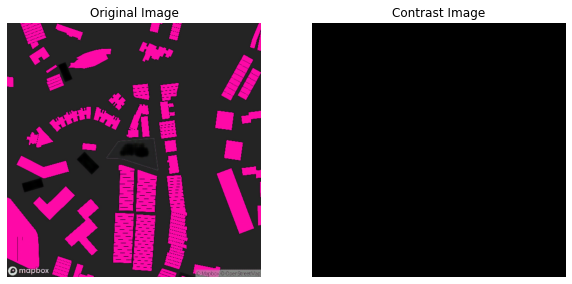

In [ ]:
blank_image = np.zeros_like(building_mask)

# Iterate through each contour
for contour in approximated_contours:
    # Calculate the bounding rectangle for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the rectangle on the blank image
    # (255) is the color (white), and 2 is the thickness of the rectangle lines
    cv2.rectangle(blank_image, (x, y), (x+w, y+h), (255), 2)

# Draw the contours on the blank image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Contrast Image')
plt.axis('off')
plt.show()


## Group rectangles

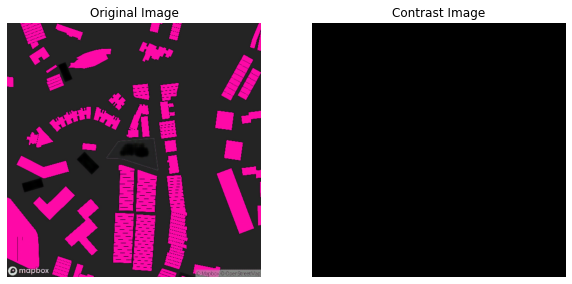

In [ ]:
import numpy as np
import cv2

def remove_nested_rectangles(rectangles):
    non_nested = []
    for rect in rectangles:
        x1, y1, w1, h1 = rect
        nested = False
        for other_rect in rectangles:
            if other_rect == rect:
                continue
            x2, y2, w2, h2 = other_rect
            if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                nested = True
                break
        if not nested:
            non_nested.append(rect)
    return non_nested

# Merge rectangles that are close to or overlap each other.
def merge_rectangles(rectangles, distance_threshold):
    merged = []
    while rectangles:
        a = rectangles.pop(0)
        to_merge = [a]
        i = 0
        while i < len(rectangles):
            b = rectangles[i]
            if is_close(a, b, distance_threshold):
                to_merge.append(b)
                rectangles.pop(i)
            else:
                i += 1
        xs = [x for x, _, w, _ in to_merge for x in [x, x+w]]
        ys = [y for _, y, _, h in to_merge for y in [y, y+h]]
        merged.append((min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)))
    return merged

def is_close(rect1, rect2, threshold):
    """
    Check if two rectangles are close to each other based on a threshold.
    """
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    distance = np.hypot(center1[0] - center2[0], center1[1] - center2[1])
    return distance < threshold

blank_image = np.zeros_like(building_mask)
rectangles = [cv2.boundingRect(contour) for contour in approximated_contours]

non_nested_rectangles = remove_nested_rectangles(rectangles)
distance_threshold = 20  #threshold
merged_rectangles = merge_rectangles(non_nested_rectangles, distance_threshold)

min_width = 15
min_height = 15
# Draw the final rectangles on the blank image, but only if they are not too small
for x, y, w, h in merged_rectangles:
    if w >= min_width and h >= min_height:
        cv2.rectangle(blank_image, (x, y), (x + w, y + h), (255), -1)  # Fill the rectangle



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Contrast Image')
plt.axis('off')
plt.show()

## Find site:building area ratio

In [ ]:
# Count the filled pixels in blank_image (white pixels after drawing rectangles)
building_pixels = np.sum(blank_image == 255)

# Count the pixels in site_mask (assuming site_mask is a binary mask where the site is marked with 1s or True)
mask_pixels = np.sum(site_mask)

# Find dimensions of image
image_w, image_h = generated_image.size

# Calculate the ratio
if mask_pixels > 0:  # To avoid division by zero
    ratio = building_pixels / mask_pixels
else:
    ratio = 0

print(f"Ratio of filled area to site mask area: {ratio:.2f}")

Ratio of filled area to site mask area: 0.00


## Find area of generated building

In [ ]:
# https://docs.mapbox.com/help/glossary/zoom-level/
meters_per_pixel = 0.597 + (0.597/2) # at 16.5x zoom
building_area = (meters_per_pixel**2) * building_pixels
site_area_ = (meters_per_pixel**2) * mask_pixels

print("Building area:", building_area, "msq")
print("Site area: ", site_area_, "msq")

Building area: 0.0 msq
Site area:  3225.3232454999998 msq


## Draw site on clean map